Week 5 · Day 5 — Train on MNIST (Digits)
Why this matters

MNIST is the “hello world” of deep learning: handwritten digits (0–9). Training a neural net to recognize them shows how all the PyTorch pieces (data, model, loss, optimizer, training loop) fit together.

Theory Essentials

MNIST dataset: 70k grayscale 28×28 digit images (train 60k, test 10k).

Flatten images (28×28 → 784 features) or use CNNs later.

Model: feedforward net (e.g., 784 → 128 → 64 → 10).

Loss: Cross-Entropy (for multi-class).

Optimizer: Adam or SGD.

Evaluation: accuracy on test set + confusion matrix.

Epoch 1: loss=0.3328
Epoch 2: loss=0.1354
Epoch 3: loss=0.0947
Epoch 4: loss=0.0716
Epoch 5: loss=0.0558
Test accuracy: 0.976


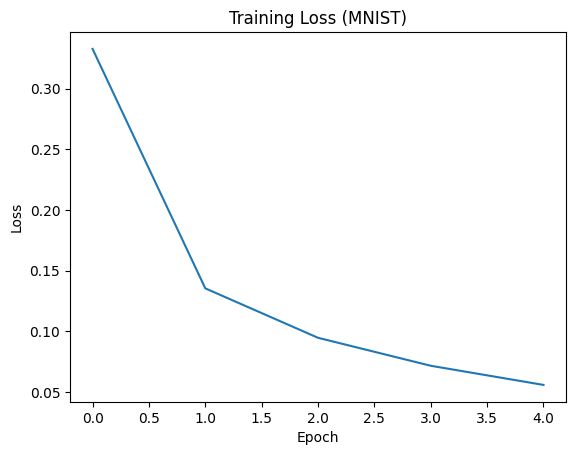

In [12]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


torch.manual_seed(42)

# ---------- Data ----------
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000, shuffle=False)

# ---------- Model ----------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)   # flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()

# ---------- Loss & Optimizer ----------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------- Training ----------
# X → images go through the model → produces predictions (y_pred), shape (64, 10).

# y → true answers, shape (64,).

# criterion(y_pred, y) matches predictions to the correct class.
train_losses = []
for epoch in range(5):
    model.train()
    total_loss = 0
    for X,y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")

# ---------- Evaluation ----------
model.eval()
correct, total = 0, 0
y_true, y_pred_all = [], []
mis_images, mis_true, mis_pred = [], [], []

with torch.no_grad():
    for X,y in test_loader:
        outputs = model(X)
        preds = outputs.argmax(1)
        correct += (preds==y).sum().item()
        total += y.size(0)

        y_true.extend(y.tolist())        # store true labels for confusion matrix
        y_pred_all.extend(preds.tolist())  # store predictions

        wrong = preds.ne(y)                      # boolean mask of mistakes
        if wrong.any():
            mis_images.extend(X[wrong].cpu())    # keep the wrong images
            mis_true.extend(y[wrong].cpu().tolist())
            mis_pred.extend(preds[wrong].cpu().tolist())

acc = correct/total
print(f"Test accuracy: {acc:.3f}")

# Loss curve
plt.plot(train_losses)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss (MNIST)")
plt.show()



1) Core (10–15 min)
Task: Change hidden sizes to (256,128). Does accuracy improve?


-Hidden size (128,64):

Epoch 1: loss=0.3328
Epoch 2: loss=0.1354
Epoch 3: loss=0.0947
Epoch 4: loss=0.0716
Epoch 5: loss=0.0558
Test accuracy: 0.976

-Hidden size (256,128):

Epoch 1: loss=0.2869
Epoch 2: loss=0.1058
Epoch 3: loss=0.0713
Epoch 4: loss=0.0514
Epoch 5: loss=0.0388
Test accuracy: 0.980

Training speed with more neurons is considerably slower. Accuracy is slightly better. Assing more neurons means the network has more capacity so training might be slower and there is a risk of overfitting.

2) Practice (10–15 min)
Task: Train for 10 epochs with SGD+momentum. Compare convergence speed with Adam.

10 epochs with SGD+momentum:

Epoch 1: loss=1.7049
Epoch 2: loss=0.5591
Epoch 3: loss=0.3954
Epoch 4: loss=0.3460
Epoch 5: loss=0.3155
Epoch 6: loss=0.2932
Epoch 7: loss=0.2740
Epoch 8: loss=0.2573
Epoch 9: loss=0.2426
Epoch 10: loss=0.2290
Test accuracy: 0.935

Adam has a faster convergnece speed and also has better accuracy.

3) Stretch (optional, 10–15 min)
Task: Compute and plot a confusion matrix for test predictions.

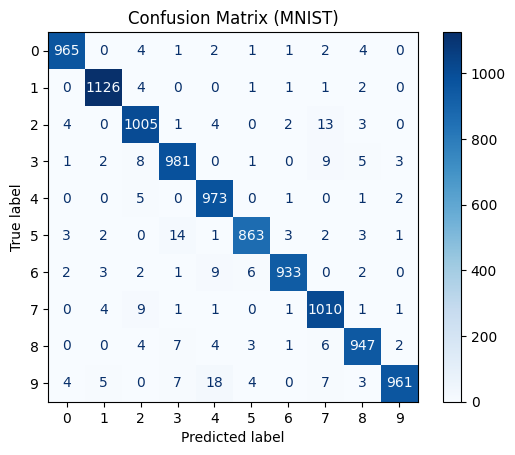

In [13]:
# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_true, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (MNIST)")
plt.show()


Mini-Challenge (≤40 min)

Task: Visualize model mistakes.
Acceptance Criteria:

Collect misclassified images from test set.

Plot at least 10 with predicted vs true labels.

Brief note on common error patterns (e.g., 4↔9 confusion).

Misclassified samples collected: 236


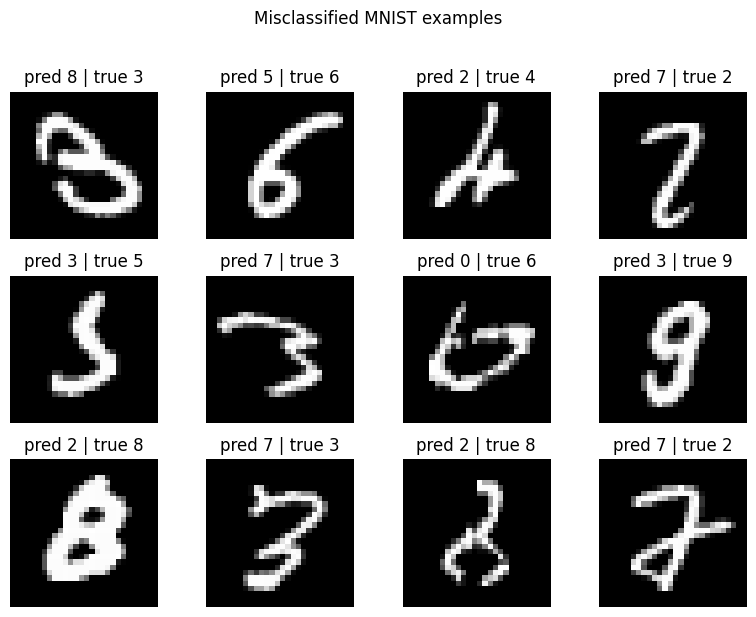

Top confusions (true → pred, count):
9 → 4: 18
5 → 3: 14
2 → 7: 13
3 → 7: 9
7 → 2: 9


In [14]:
# ---------- Visualize mistakes ----------
print(f"Misclassified samples collected: {len(mis_images)}")
n = min(12, len(mis_images))   # show 12 if available
rows, cols = 3, 4

fig, axes = plt.subplots(rows, cols, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
    if i < n:
        ax.imshow(mis_images[i].squeeze(), cmap="gray")
        ax.set_title(f"pred {mis_pred[i]} | true {mis_true[i]}")
    ax.axis("off")
plt.suptitle("Misclassified MNIST examples", y=1.02)
plt.tight_layout()
plt.show()

#Brief note on common error patterns

from collections import Counter
pairs = Counter(zip(mis_true, mis_pred))             # (true, pred)
top = pairs.most_common(5)
print("Top confusions (true → pred, count):")
for (t, p), c in top:
    print(f"{t} → {p}: {c}")


Notes / Key Takeaways

PyTorch pipeline: DataLoader → Model → Loss → Optimizer → Training loop.

ReLU hidden + CrossEntropy loss = strong baseline.

Adam usually converges faster than SGD (but SGD may generalize better).

Evaluation beyond accuracy (confusion matrix, error inspection) gives insight.

MNIST is easy — the point is learning the process.

Reflection

Why do we flatten 28×28 images instead of feeding them raw?

Why might a confusion matrix reveal insights that accuracy alone can’t?

1. Why do we flatten 28×28 images instead of feeding them raw?
Fully connected (linear) layers expect 1D vectors, not 2D grids. Flattening converts each 28×28 image (a matrix of 784 pixels) into a vector of length 784 so the layer can process it. In this setup, the network doesn’t use the spatial structure of the image — every pixel is treated as just another input feature. (Later, when we use CNNs, we’ll keep the 2D structure to exploit patterns like edges and shapes.)

2. Why might a confusion matrix reveal insights that accuracy alone can’t?
Accuracy only tells us the percentage of correct predictions overall. A confusion matrix shows which classes are being confused with each other. For example, you might see that 4’s are often misclassified as 9’s, or 5’s as 3’s, even if the overall accuracy is high. This gives deeper insight into error patterns, model weaknesses, and where improvements (like better features or more data) are needed.